In [4]:
# check available gpus
# !nvidia-smi

In [5]:
import torch
import matplotlib.pyplot as plt

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


In [4]:
# learn texture from image
from modules.Renderer import Renderer
from modules.utils import remove_background ,squared_image

verts_T_paths = ['data/verts_T/0002_c1s2_064446_01.pkl']
# verts_T_paths = ['data/verts_T/0002_c2s1_123141_01.pkl']
euler_list = [[0,0,0]]#,[0,0,180]]

tm_paths = ['data/meta/default_texture.jpg']
# tm_paths = ['changed_texture_fpp_1.jpg']

image_path = 'data/images/0002_c1s2_064446_01.jpg'
seg_mask_path = "data/seg/0002_c1s2_064446_01.png" 

In [201]:
image_resolution = 256#128#256 # 512

In [202]:
renderer = Renderer(image_resolution=image_resolution,device=device,blur_radius=0.0)
print("1")
renderer.load_inputs(verts_T_paths,tm_paths = tm_paths,
                     euler_list = euler_list)
print("2")
images = renderer.render()

1
2


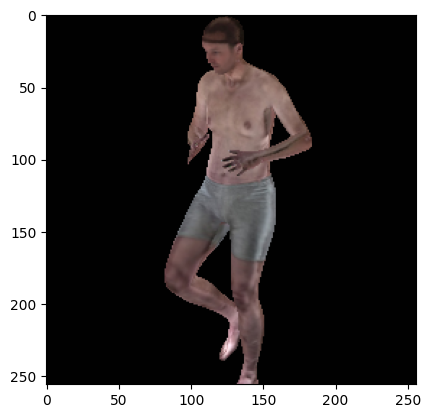

In [203]:
renderer.show()

In [204]:

tgt = remove_background(image_path,seg_mask_path)
tgt = squared_image(tgt)
# plt.imshow(tgt)
# tgt.shape
# resize the image to 512,512
from skimage.transform import resize
tgt = resize(tgt,(image_resolution,image_resolution))


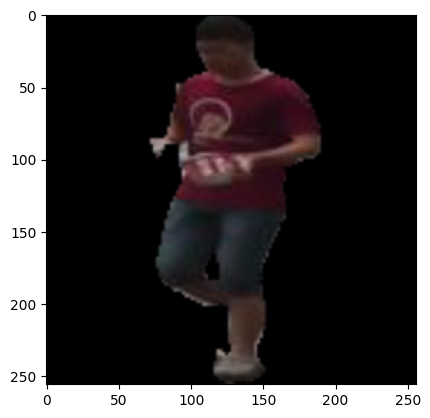

In [205]:
plt.imshow(tgt)

In [206]:
from loss_utils import PerceptualTextureLoss, tv_loss


In [207]:
texture_loss = PerceptualTextureLoss()
tgt = torch.from_numpy(tgt).permute(2,0,1).float().unsqueeze(0).to(device)


Setting up Perceptual loss..


/home/cds/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cds/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Done


In [ ]:
# training loop to learn texture and T from image
params = [ renderer.texture_map] #renderer.verts,renderer.T
optim = torch.optim.Adam(params,lr=0.1)


for i in range(1000):
    optim.zero_grad()
    images = renderer.render()

    images = images.permute(0,3,1,2)[:,:3,:,:].float().to(device)

    # resize both to 256,256
    
    
    perceptual_loss = texture_loss(images,tgt)
    loss = perceptual_loss # + 0.5 * tv_loss(renderer.texture_map)
    print('i :' , i,'loss:',loss.item())
    



    # diff = images[0,...,:3] - torch.from_numpy(tgt).to(device)
    # loss = torch.sum(diff**2) + 0.5 * tv_loss(renderer.texture_map)
    loss.backward()
    optim.step()
    # print(loss.item())
    if i%300 == 0:
        plt.figure(figsize=(3,3))
        plt.imshow(images[0,...,:3].cpu().detach().numpy().clip(0,1))
        plt.axis('off')
        plt.show()
        
        # print(renderer.T)
        # print(renderer.texture_map)
        # print(renderer.verts)
        print('loss:',loss.item())
 


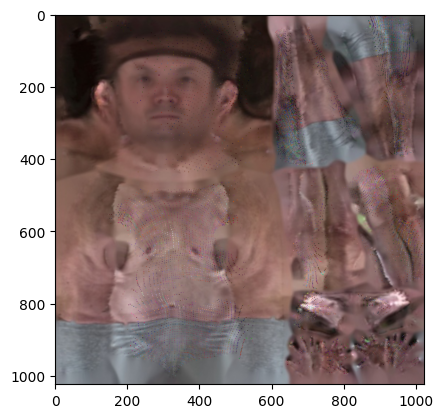

In [217]:
import numpy as np
texture = renderer.texture_map.cpu().detach().numpy()[0]
texture = texture/255
# texture = np.transpose(texture,(1,2,0))
plt.imshow(texture.clip(0,1))


In [219]:
# save texture
plt.imsave("data/exp/changed_texture_perceptual.jpg",texture.clip(0,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


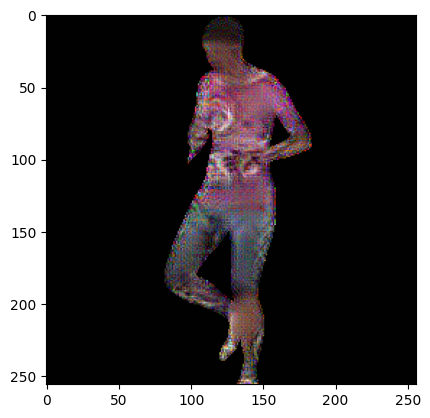

In [218]:
renderer.show()

In [1]:
import torch

In [2]:
# saple code for using grid_sample
input = torch.randn(1, 3, 4, 4)
grid = torch.randn(1, 4, 4, 2)
output = torch.nn.functional.grid_sample(input, grid)

/home/cds/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [14]:
# output.shape
# read image_path 
from skimage.io import imread
image = imread(image_path)
image = torch.from_numpy(image).unsqueeze(0).permute(0,3,1,2) #[1, 3, 128, 64])
image.dtype

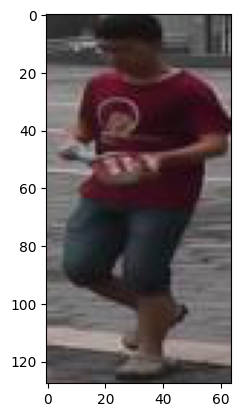

In [17]:
plt.imshow(image[0].permute(1,2,0).numpy())

In [27]:
#uniform sample from 0,1
grid = torch.rand(1,256,256,2)
grid = grid * 2 - 1
output = torch.nn.functional.grid_sample(image.float(), grid.float())
output.shape

/home/cds/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


torch.Size([1, 3, 256, 256])

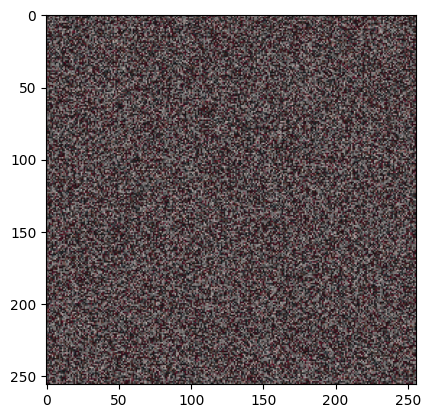

In [26]:
#plot output
plt.imshow(output[0].permute(1,2,0).numpy()/255.0)

In [1]:
from modules.ashok_utils import read_image,plot_image
image = read_image(image_path)
plot_image(image)

ModuleNotFoundError: No module named 'modules.ashok_utils'

In [8]:
from modules.basic_utils import read_image,plot_image

In [9]:
read_image(image_path).shape

NameError: name 'image_path' is not defined